# Cointegration Testing

_This setup code is required to run in an IPython notebook_

In [1]:
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

We will look at the spot prices of crude oil measured in Cushing, OK for
West Texas Intermediate Crude, and Brent Crude. The underlying data in this
data set come from the [U.S. Energy Information Administration](https://www.eia.gov/).

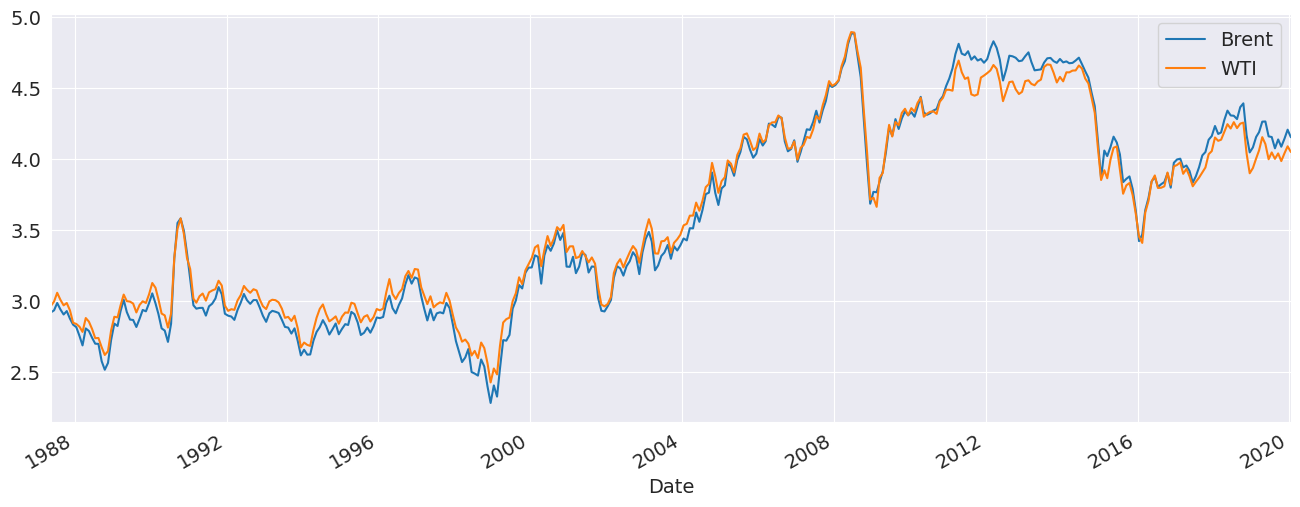

In [2]:
import numpy as np
from arch.data import crude

data = crude.load()
log_price = np.log(data)

ax = log_price.plot()
xl = ax.set_xlim(log_price.index.min(), log_price.index.max())

We can verify these both of these series appear to contains unit roots
using Augmented Dickey-Fuller tests. The p-values are large indicating
that the null cannot be rejected.

In [3]:
from arch.unitroot import ADF

ADF(log_price.WTI, trend="c")

Test Statistic,-1.780
P-value,0.391
Lags,1


In [4]:
ADF(log_price.Brent, trend="c")

Test Statistic,-1.655
P-value,0.454
Lags,1


The Engle-Granger test is a 2-step test that first estimates a cross-sectional
regression, and then tests the residuals from this regression using an
Augmented Dickey-Fuller distribution with modified critical values. The cross-sectional regression is

$$ Y_t = X_t \beta + D_t \gamma + \epsilon_t $$

where $Y_t$ and $X_t$ combine to contain the set of variables being tested for
cointegration and $D_t$ are a set of deterministic regressors that might include
a constant, a time trend, or a quadratic time trend. The trend is specified using
`trend` as

* `"n"`: No trend
* `"c"`: Constant
* `"ct"`: Constant and time trend
* `"ctt"`: Constant, time and quadratic trends

Here we assume that that cointegrating relationship is exact so that no
deterministics are needed.

In [5]:
from arch.unitroot import engle_granger

eg_test = engle_granger(log_price.WTI, log_price.Brent, trend="n")
eg_test

Test Statistic,-3.468
P-value,0.007
ADF Lag length,0
Estimated Root ρ (γ+1),0.939


The `plot` method can be used to plot the model residual.  We see that while this appears to be mean 0, it might have a trend in it.

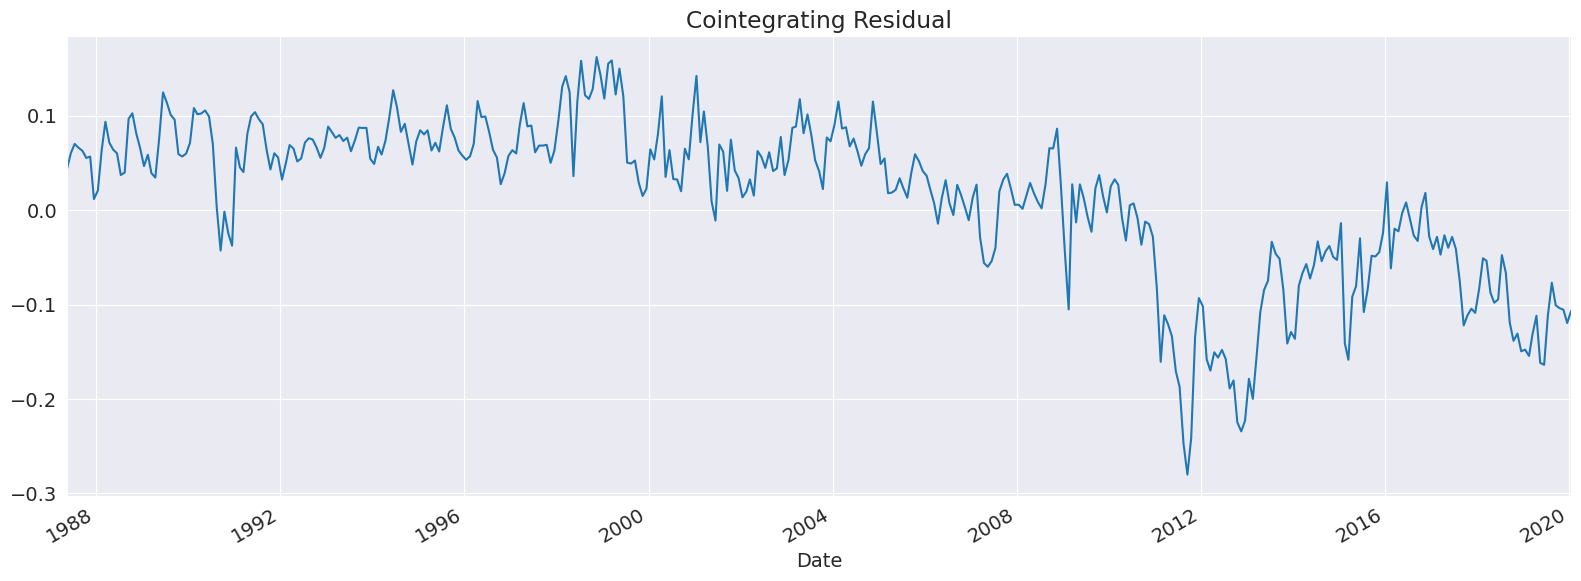

In [6]:
fig = eg_test.plot()

The estimated cointegrating vector is exposed through he `cointegrating_vector` property.  Here we see it is very close to $[1, -1]$, indicating a simple no-arbitrage relationship.

In [7]:
eg_test.cointegrating_vector

WTI      1.000000
Brent   -1.000621
dtype: float64

We can rerun the test with both a constant and a time trend to see how this affects the conclusion. We firmly reject the null of no cointegration even with this alternative assumption.

In [8]:
eg_test = engle_granger(log_price.WTI, log_price.Brent, trend="ct")
eg_test

Test Statistic,-5.837
P-value,0.000
ADF Lag length,0
Estimated Root ρ (γ+1),0.840


In [9]:
eg_test.cointegrating_vector

WTI      1.000000
Brent   -0.931769
const   -0.296939
trend    0.000185
dtype: float64

The residuals are clearly mean zero but show evidence of a structural break around the financial crisis of 2008.

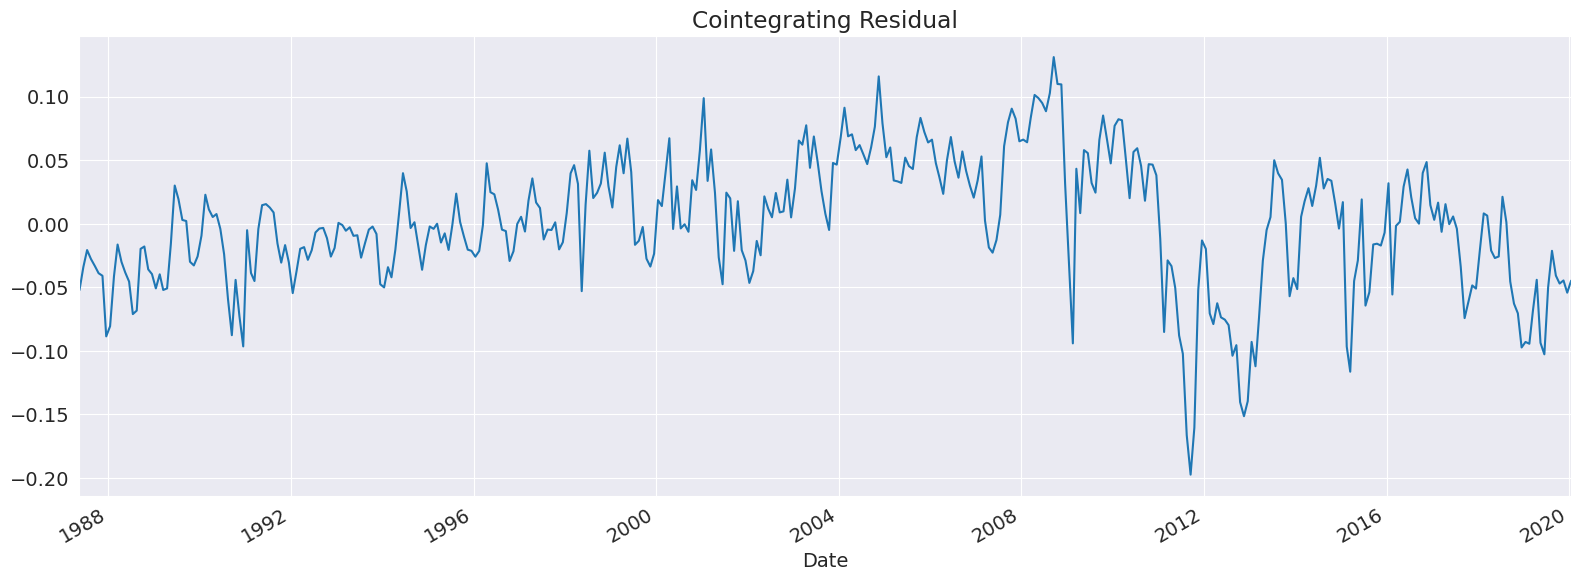

In [10]:
fig = eg_test.plot()

To investigate the changes in the 2008 financial crisis, we can re-run the test on only the pre-crisis period.

In [11]:
eg_test = engle_granger(log_price[:"2008"].WTI, log_price[:"2008"].Brent, trend="n")
eg_test

Test Statistic,-4.962
P-value,0.000
ADF Lag length,0
Estimated Root ρ (γ+1),0.825


These residuals look quite a bit better although it is possible the break in the cointegrating vector happened around 2005 when oil prices first surged.

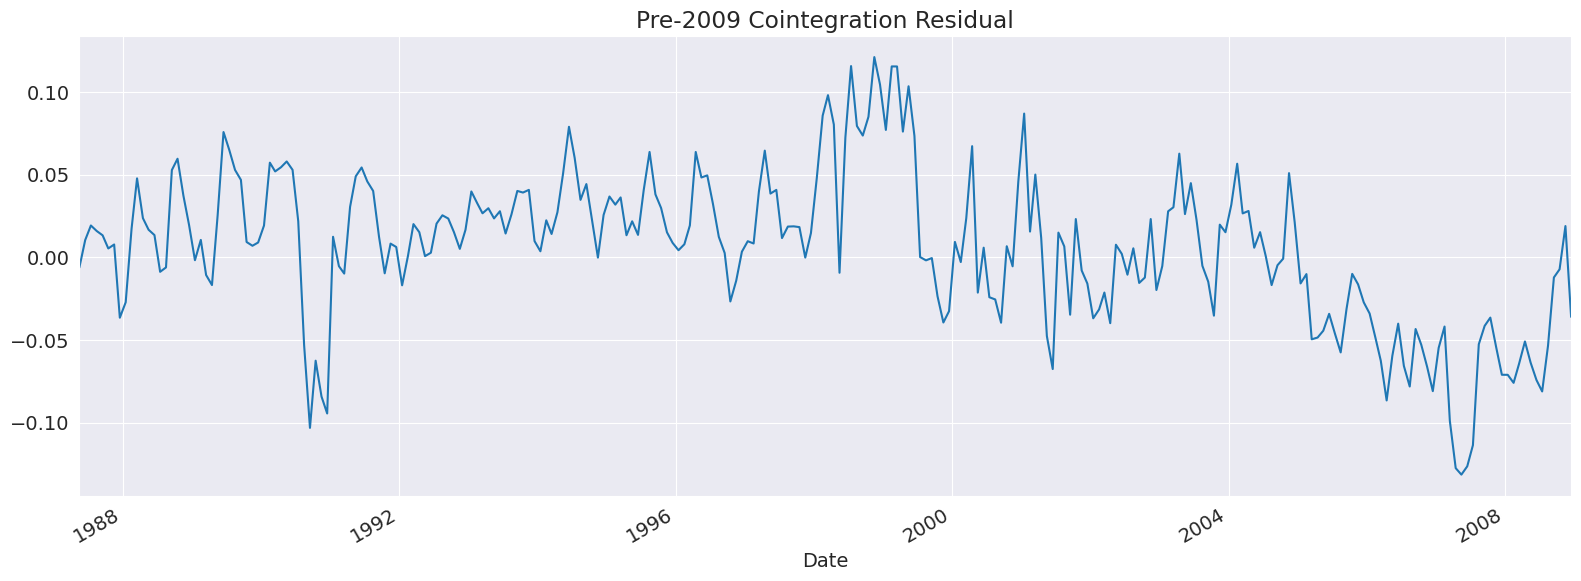

In [12]:
fig = eg_test.plot()
ax = fig.get_axes()[0]
title = ax.set_title("Pre-2009 Cointegration Residual")

## Phillips-Ouliaris

The Phillips-Ouliaris tests consists four distinct tests.  Two are similar to the Engle-Granger test, only using a Phillips & Perron-like approach replaces the lags in the ADF test with a long-run variance estimator. The other two use variance-ratio like approaches to test.  In both cases the test stabilizes when there is no cointegration and diverges due to singularity of the covariance matrix of the I(1) time series when there is cointegration. 

* $Z_t$ - Like PP using the t-stat of the AR(1) coefficient in an AR(1) of the residual from the cross-sectional regression.
* $Z_\alpha$ - Like PP using $T(\alpha-1)$ and a bias term from the same AR(1)
* $P_u$ - A univariate variance ratio test. 
* $P_z$ - A multivariate variance ratio test.

The four test statistics all agree on the crude oil data.

The $Z_t$ and $Z_\alpha$ test statistics are both based on the quantity $\gamma=\rho-1$ from the regression $y_t = d_t \Delta + \rho y_{t-1} + \epsilon_t$. The null is rejected in favor of the alternative when $\gamma<0$ so that the test statistic is _below_ its critical value.

In [13]:
from arch.unitroot.cointegration import phillips_ouliaris

po_zt_test = phillips_ouliaris(
    log_price.WTI, log_price.Brent, trend="c", test_type="Zt"
)
po_zt_test.summary()

Test Statistic,-5.357
P-value,0.000
Kernel,Bartlett
Bandwidth,10.185


In [14]:
po_za_test = phillips_ouliaris(
    log_price.WTI, log_price.Brent, trend="c", test_type="Za"
)
po_za_test.summary()

Test Statistic,-53.531
P-value,0.000
Kernel,Bartlett
Bandwidth,10.185


The $P_u$ and $P_z$ statistics are variance ratios where under the null the numerator and denominator are balanced and so converge at the same rate. Under the alternative the denominator converges to zero and the statistic diverges, so that rejection of the null occurs when the test statistic is _above_ a critical value.

In [15]:
po_pu_test = phillips_ouliaris(
    log_price.WTI, log_price.Brent, trend="c", test_type="Pu"
)
po_pu_test.summary()

Test Statistic,102.868
P-value,0.000
Kernel,Bartlett
Bandwidth,14.648


In [16]:
po_pz_test = phillips_ouliaris(
    log_price.WTI, log_price.Brent, trend="c", test_type="Pz"
)
po_pz_test.summary()

Test Statistic,114.601
P-value,0.000
Kernel,Bartlett
Bandwidth,14.648


The cointegrating residual is identical to the EG test since the first step is identical.

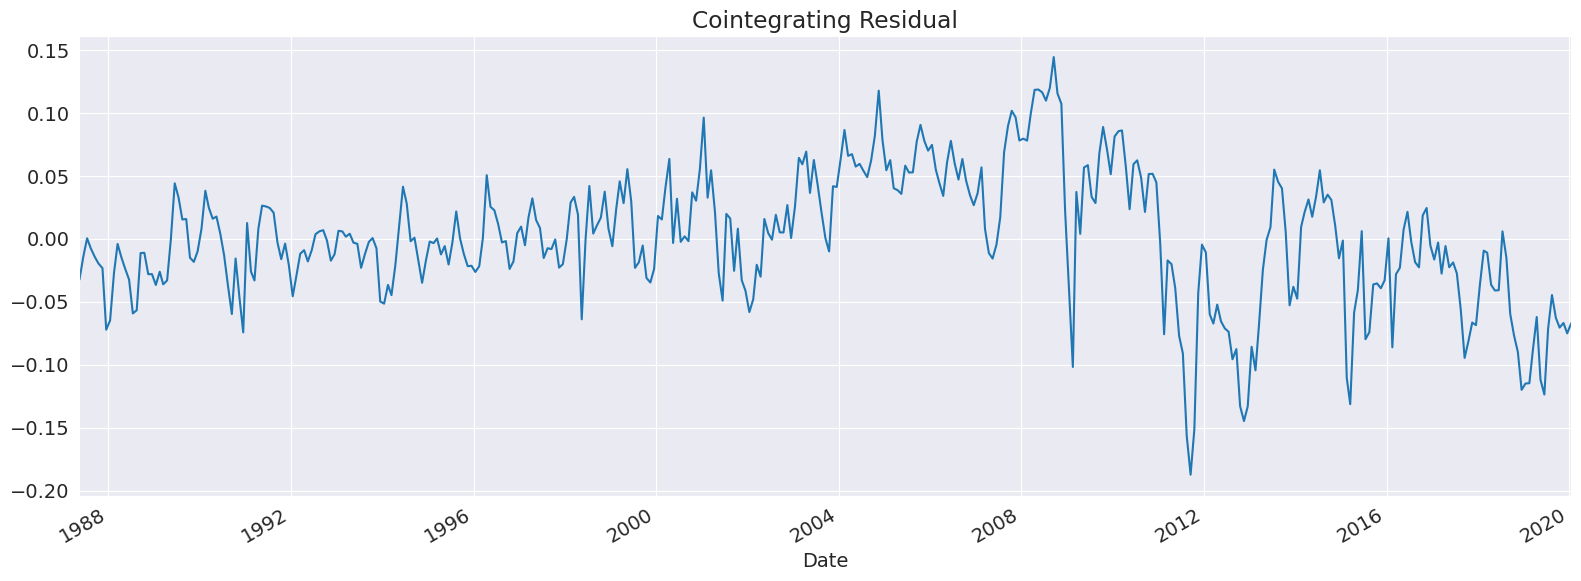

In [17]:
fig = po_zt_test.plot()